# Conectando com o Banco de Dados

In [4]:
import psycopg2
import os
import json

# Load the database parameters
db_params_path = os.path.join("scripts", "db_params.json")
with open(db_params_path, "r") as f:
    db_params = json.load(f)

# Establish a connection
connection = psycopg2.connect(**db_params)

## Teste

In [5]:
import pandas as pd

n = 0

# SQL query
sql_query = f"""SELECT problem_id, COUNT(DISTINCT user_id)
                FROM questions_userlog
                GROUP BY problem_id
                HAVING COUNT(DISTINCT user_id) >= {n};"""

# Load data into a Pandas dataframe
df = pd.read_sql_query(sql_query, connection)

# Take a look at the data
df.describe()

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/808633263.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


problem_id        count
count  138.000000   138.000000
mean   678.195652   369.673913
std    268.866718   539.780872
min      3.000000     1.000000
25%    743.250000     4.000000
50%    783.500000    20.000000
75%    818.750000   893.750000
max    857.000000  1813.000000

# Análise Exploratória

## Quantas questões existem no banco de dados?

In [6]:
# SQL query
sql_query = f"""SELECT *
                FROM questions_problem
                """

# Load data into a Pandas dataframe
questions_df = pd.read_sql_query(sql_query, connection)

# Count lines
questions_df.count()

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/593237104.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  questions_df = pd.read_sql_query(sql_query, connection)


id                     842
title                  842
content                842
difficulty             842
link                   842
retrieved_date         842
crawler                842
hint                   842
test_case_generator    124
question_type          842
options                842
dtype: int64

### Quantas questões com resposta existem no banco de dados?

In [7]:
n = 1

# SQL query
sql_query = f"""SELECT problem_id, COUNT(DISTINCT user_id)
                FROM questions_userlog
                GROUP BY problem_id
                HAVING COUNT(DISTINCT user_id) >= {n};"""

# Load data into a Pandas dataframe
df = pd.read_sql_query(sql_query, connection)

print(f"Number of problems with at least {n} answer(s) from distinct users: {len(df)}")

/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/650427698.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


Number of problems with at least 1 answer(s) from distinct users: 138


## Quantas soluções existem no banco de dados?

Transformando tabela de soluções em Dataframe:

In [8]:
# SQL query
sql_query = f"""SELECT *
                FROM questions_userlog
                """

# Load data into a Pandas dataframe
solutions_df = pd.read_sql_query(sql_query, connection)

solutions_df.describe()


/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/3692574933.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  solutions_df = pd.read_sql_query(sql_query, connection)


id  seconds_in_code  seconds_in_page  seconds_to_begin  \
count  434337.000000     4.343370e+05    434337.000000     434337.000000   
mean   351012.579948     8.547523e+02      2805.806567        335.728480   
std    125402.352557     8.804527e+03     12750.494749       3536.405048   
min     84420.000000     0.000000e+00         0.000000          0.000000   
25%    242438.000000     9.200000e+01       314.000000          3.000000   
50%    351023.000000     1.940000e+02       796.000000         15.000000   
75%    459607.000000     3.900000e+02      1885.000000         79.000000   
max    568191.000000     1.042544e+06    504133.000000     499615.000000   

       solution_lines     problem_id        user_id  test_case_hits  \
count   434337.000000  434337.000000  434337.000000   426418.000000   
mean        11.139997     803.728800    1843.444443       26.622722   
std          9.153649      52.135296     632.069444       39.219658   
min          1.000000       3.000000       1.000000        0.000000   
25%          7.000000     804.000000    1323.000000        0.000000   
50%         10.000000     813.000000    1762.000000        0.000000   
75%         14.000000     827.000000    2348.000000       53.000000   
max       3859.000000     857.000000    3421.000000      100.000000   

       user_class_id  
count  434337.000000  
mean       69.952010  
std        27.920784  
min         2.000000  
25%        54.000000  
50%        73.000000  
75%        88.000000  
max       143.000000

In [9]:
solutions_count = len(solutions_df)
print(f"Number of solutions: {solutions_count}")

Number of solutions: 434337


## Quantas são as soluções sem contar as tentativas repetidas em cada questão?

Contamos apenas a última solução submetida por um usuário para cada questão.

Em outras palavras, queremos o número de soluções com pares únicos de [problem_id, user_id].

In [10]:
# Count number of solutions with unique problem_id/user_id pairs 

unique_solutions_count = len(solutions_df.groupby(["problem_id", "user_id"]))
print(f"Number of unique solutions: {unique_solutions_count}")
percentage = round(unique_solutions_count/solutions_count * 100, 1)
print(f"Counting only unique solutions, we need look just at {percentage}% of the solutions.")

Number of unique solutions: 51015
Counting only unique solutions, we need look just at 11.7% of the solutions.


## Quais são as estatísticas das soluções únicas?

Gerando um dataframe de soluções únicas

In [11]:
# Sort the solutions dataframe by 'user_id' and 'problem_id' and 'timestamp' in descending order
sorted_solutions_df = solutions_df.sort_values(by=['user_id', 'problem_id', 'timestamp'], ascending=[True, True, True])

# Use groupby to group by 'user_id' and 'problem_id' and select the last solution in each group
last_solution_df = sorted_solutions_df.groupby(['user_id', 'problem_id']).last().reset_index()

In [12]:
last_solution_df.describe()

user_id    problem_id             id  seconds_in_code  \
count  51015.000000  51015.000000   51015.000000     51015.000000   
mean    1829.338528    799.172734  351632.839655       506.568735   
std      656.720386     63.597801  128877.753572      7900.330112   
min        1.000000      3.000000   84427.000000         0.000000   
25%     1266.000000    800.000000  235979.500000        42.000000   
50%     1715.000000    815.000000  351300.000000       126.000000   
75%     2355.000000    828.000000  464049.000000       251.000000   
max     3421.000000    857.000000  568191.000000    940115.000000   

       seconds_in_page  seconds_to_begin  solution_lines  test_case_hits  \
count     51015.000000      51015.000000    51015.000000    50029.000000   
mean       1785.642635        334.944036       11.333392       93.099083   
std       10297.295393       4604.079000        6.793658       24.535300   
min           0.000000          0.000000        1.000000        0.000000   
25%         137.000000          3.000000        7.000000      100.000000   
50%         443.000000         13.000000       10.000000      100.000000   
75%        1150.000000         65.000000       14.000000      100.000000   
max      504133.000000     499615.000000      123.000000      100.000000   

       user_class_id  
count   51015.000000  
mean       69.161756  
std        29.301950  
min         2.000000  
25%        38.000000  
50%        73.000000  
75%        88.000000  
max       143.000000

#

## Quantos são os alunos no banco de dados?

In [13]:
# TODO cortar os usuarios que são staff ou não estao ativos

# SQL query
sql_query = f"""SELECT id
                FROM auth_user
                """

# Load data into a Pandas dataframe
students_df = pd.read_sql_query(sql_query, connection)

# Count lines
print(f"Number of users: {len(students_df)}")

Number of users: 3162


/var/folders/r4/lsk7h_t97_z0qpppcnz96n700000gn/T/ipykernel_15377/3031740989.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  students_df = pd.read_sql_query(sql_query, connection)


## Como é o histograma do número de soluções por questão?

In [15]:
sols_per_question = last_solution_df.groupby(['problem_id'])['id'].count()
print(f"Number of questions with solutions: {len(sols_per_question)}")

Number of questions with solutions: 138


### Histograma Original

In [16]:
import matplotlib
import matplotlib.pyplot as plt

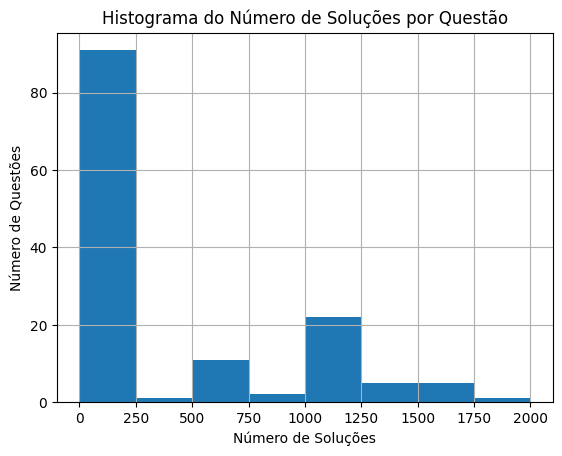

In [49]:
sols_per_question.hist(bins=range(0, 2001, 250))

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma do Número de Soluções por Questão')

# Show the histogram
plt.show()

### Avaliando questões com poucas soluções (<= 50)

Number of questions with less than 250 solutions: 91


Text(0.5, 1.0, 'Histograma Soluções por Questão (< 250 soluções)')

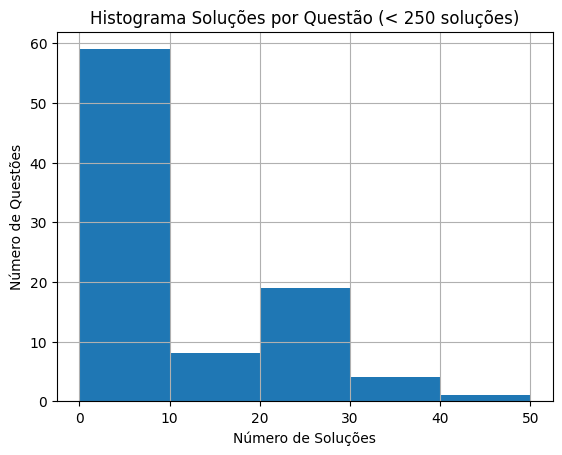

In [47]:
few_sols_series = sols_per_question[sols_per_question < 250]
few_sols_series.hist(bins=range(0, 51, 10))

print(f"Number of questions with less than 250 solutions: {len(few_sols_series)}")

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma Soluções por Questão (< 250 soluções)')

### Questões com apenas 1 solução (não são interessantes para o Overcode)

In [51]:
one_sol_series = sols_per_question[sols_per_question == 1]
print(f"Number of questions with only one solution: {len(one_sol_series)}")

Number of questions with only one solution: 14


### Avaliando questões com muitas soluções (> 250)

Number of questions with more than 250 solutions: 47


Text(0.5, 1.0, 'Histograma Soluções por Questão (> 250 soluções)')

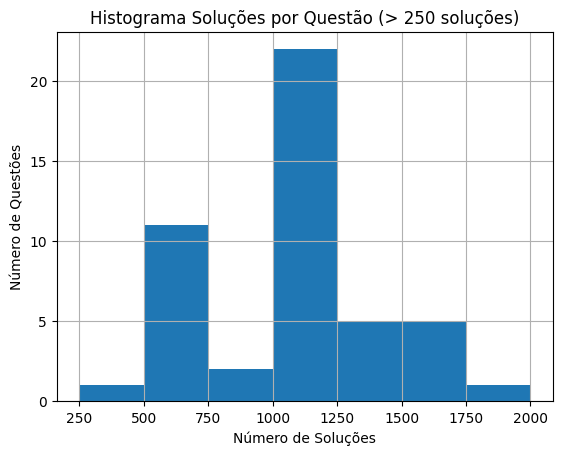

In [50]:
many_sols_series = sols_per_question[sols_per_question > 250]
many_sols_series.hist(bins=range(250, 2001, 250))

print(f"Number of questions with more than 250 solutions: {len(many_sols_series)}")

# Add labels and a title
plt.xlabel('Número de Soluções')
plt.ylabel('Número de Questões')
plt.title('Histograma Soluções por Questão (> 250 soluções)')

# Análise dos Dados do Overcode

## Teste com Problema Individual

### Coletar dados do Machine Teaching e processar com Overcode

In [200]:
from master_script import run_master_script

problem_id = 814

run_master_script(problem_id, interface=False)

Tidying 2204
Tidying 2137
Tidying 2026
expected ':' (python_minifier.minify source, line 1)
Tidying 2321
Tidying 1059
Tidying 1288
('EOF in multi-line statement', (4, 0))
Tidying 1119
Tidying 2292
Tidying 915
Tidying 1564
Tidying 1475
Tidying 944
Tidying 1486
Tidying 1954
Tidying 1746
Tidying 1606
Tidying 1597
Tidying 970
Tidying 1690
Tidying 1501
Tidying 1441
Tidying 921
Tidying 1550
Tidying 1882
Tidying 1632
Tidying 1931
Tidying 983
Tidying 1970
Tidying 1400
Tidying 1892
Tidying 931
Tidying 1540
Tidying 1451
Tidying 960
inconsistent use of tabs and spaces in indentation (python_minifier.minify source, line 3)
Tidying 1680
Tidying 1647
Tidying 1944
Tidying 1496
Tidying 954
Tidying 1465
Tidying 1574
Tidying 1434
Tidying 1109
Tidying 1298
unindent does not match any outer indentation level (python_minifier.minify source, line 3)
Tidying 2220
Tidying 1049
Tidying 1158
Tidying 1018
Tidying 1389
unindent does not match any outer indentation level (python_minifier.minify source, line 7)
Tid

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
29

39.43883600000001
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
26

39.450811
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
31

39.456902
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
18

39.468869
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
34

42.018578000000005
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
28

42.028339
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
31

42.03899700000001
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
28

46.06230500000001
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
31

46.071837
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
30

46.07950700000001
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
29

46.087675000000004
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Vi

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 27, in <module>
TypeError: faltas() missing 2 required positional arguments: 'lista2' and 'lista3'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 27, in <module>
TypeError: faltas() missing 2 required positional arguments: 'lista2' and 'lista3'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
34

49.48808100000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
28

49.493836
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
31

49.497663
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
30

49.50545700000001
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdou

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 24, in <module>
  File "<string>", line 6, in faltas
TypeError: 'list' object is not callable
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 24, in <module>
  File "<string>", line 6, in faltas
TypeError: 'list' object is not callable
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/e

Running logger on 1497
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
34

50.02434100000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
28

50.029538
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
31

50.034144
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina"

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
41

51.13716500000001
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
20

51.144587

Running logger on 1094
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
34

51.15220600000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
28

51.16267500000001
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edge

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 11, in <module>
NameError: name 'jogos' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 11, in <module>
NameError: name 'jogos' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_

Running logger on 1012
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
34

51.886053000000004
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
28

51.893326
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
31

51.899782
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina",

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 34, in <module>
  File "<string>", line 12, in faltas
NameError: name 'faltas1' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 34, in <module>
  File "<string>", line 12, in faltas
NameError: name 'faltas1' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
31

52.406437
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
18

52.41072
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
41

52.413955
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
20

52.41888900000001

Running logger on 1204
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
28

53.229265
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
31

53.24261800000001
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
30

53.257514
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 34, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 34, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
18

55.790496000000005
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
41

55.796887
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
20

55.80515100000001

Running logger on 1265
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
34

55.81751
	print(faltas([["Terr

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
41

56.382789
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
20

56.388018

Running logger on 1116
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
34

56.397397
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
28

56.404613
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

56.874703
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

56.881963999999996
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

56.885940000000005
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

56.89582800000001
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

56.89953200000001
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2,

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
31

56.926964
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
30

56.93165900000001
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
29

56.93744100000001
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
26

56.942192000000006
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

57.962357
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

57.96529700000001

Running logger on 1017
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
34

57.969128
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
28

57.973425000000006
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2,

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 26, in <module>
  File "<string>", line 7, in faltas
AttributeError: 'NoneType' object has no attribute 'remove'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 26, in <module>
  File "<string>", line 7, in faltas
AttributeError: 'NoneType' object has no attribute 'remove'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
41

59.602334
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
20

59.611666

Running logger on 1382
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
34

59.62272300000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
28

59.628868
	print(faltas([["Ilhas Marshall", "S\u00e3o To

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
34

60.10571300000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
28

60.110888
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
31

60.11486000000001
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
30

60.120159
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 26, in <module>
  File "<string>", line 8, in faltas
NameError: name 'faltime1' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 26, in <module>
  File "<string>", line 8, in faltas
NameError: name 'faltime1' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src

Running logger on 1294
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

62.023432
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

62.02970500000001
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

62.035619
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 31, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 31, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

Running logger on 1306
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
34

67.628029
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
28

67.637675
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
31

67.644834
	print(faltas([["Ge\u00f3rgia",

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 24, in <module>
  File "<string>", line 5, in faltas
TypeError: unsupported operand type(s) for +: 'int' and 'list'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 24, in <module>
  File "<string>", line 5, in faltas
TypeError: unsupported operand type(s) for +: 'int' and 'list'
Traceback (most recent call last):
  File "/Users/artsasse/Deskt

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
20

68.068054

Running logger on 1001
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
34

68.08391400000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
28

68.098245
	print(fa

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 23, in <module>
TypeError: faltas() missing 2 required positional arguments: 'lista1' and 'lista2'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 23, in <module>
TypeError: faltas() missing 2 required positional arguments: 'lista1' and 'lista2'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

68.856752
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

68.863022

Running logger on 1100
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
34

68.874401
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
28

68.879552
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5,

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

Running logger on 1458
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
34

69.651123
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
28

69.661141
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
31

69.67803500000001
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", 

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 23, in <module>
  File "<string>", line 5, in faltas
TypeError: unsupported operand type(s) for +: 'int' and 'list'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 23, in <module>
  File "<string>", line 5, in faltas
TypeError: unsupported operand type(s) for +: 'int' and 'list'
Traceback (most recent call last):
  File "/Users/artsasse/Deskt

Running logger on 1394
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
34

70.692267
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
28

70.696713
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
31

70.700299
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 27, in <module>
TypeError: faltas() missing 3 required positional arguments: 'timeB', 'faltasA', and 'faltasB'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 27, in <module>
TypeError: faltas() missing 3 required positional arguments: 'timeB', 'faltasA', and 'faltasB'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Ove

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

70.939232
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

70.944505
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

70.949619

Running logger on 1227
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
34

70.960261
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
2

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
31

71.703503
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
30

71.711054
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
29

71.720034
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
26

71.72856300000001
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
26

72.400859
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
31

72.410595
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
18

72.417733
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
41

72.426567
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

72.53457300000001
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

72.54166500000001
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

72.545038
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

72.547736
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

72.550403
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0,

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
18

74.68204300000001
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
41

74.689722
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
20

74.697714

Running logger on 1903
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
34

74.70850300000001
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 35, in <module>
  File "<string>", line 9, in faltas
IndexError: list index out of range
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 35, in <module>
  File "<string>", line 9, in faltas
IndexError: list index out of range
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

74.85746900000001
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

74.86429100000001
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

74.86948100000001
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

74.874025
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 35, in <module>
  File "<string>", line 9, in faltas
IndexError: list index out of range


stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
28

74.956539
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
31

74.964772
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
30

74.975069
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
29

74.985381
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["I

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 29, in <module>
TypeError: faltas() missing 1 required positional argument: 'time2'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 29, in <module>
TypeError: faltas() missing 1 required positional argument: 'time2'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

75.22234900000001
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

75.228482
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

75.23236800000001
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

75.236864
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

75.241483
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Cambo

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 29, in <module>
TypeError: faltas() missing 1 required positional argument: 'time2'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 29, in <module>
TypeError: faltas() missing 1 required positional argument: 'time2'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
41

75.295303
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
20

75.301328

Running logger on 1701
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
34

75.309469
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
28

75.320002
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 7, in <module>
TypeError: string indices must be integers
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 7, in <module>
TypeError: string indices must be integers
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str,

Running logger on 1199
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
34

76.191883
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
28

76.197959
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
31

76.204414
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]]

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
20

76.93163100000001

Running logger on 946
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

76.935455
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

76.93967500000001
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

76.942496
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", 

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 23, in <module>
TypeError: faltas() missing 2 required positional arguments: 'listaB' and 'listaC'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 23, in <module>
TypeError: faltas() missing 2 required positional arguments: 'listaB' and 'listaC'
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
34

77.035803
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
28

77.04387200000001
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
31

77.050655
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
30

77.058097
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["E

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
18

78.776947
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
41

78.783629
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
20

78.789209

Running logger on 1278
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

78.794038
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
18

78.897625
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
41

78.901627
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
20

78.905713

Running logger on 947
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
34

78.913566
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout


Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

Running logger on 1704
running do_logger_run
	print(faltas([["Ilhas Virgens (Estados Unidos)", "Ilha Pitcairn", [0, 10]], ["Ilhas Virgens (Estados Unidos)", "Alb\u00e2nia", [7, 3]], ["Ilha Pitcairn", "Alb\u00e2nia", [6, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
34

80.371311
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
28

80.37527200000001
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
31

80.38082800000001
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herz

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 4, in <module>
NameError: name 'a' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 4, in <module>
NameError: name 'a' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, u

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
31

81.177712
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
30

81.18505400000001
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
29

81.190225
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 7]], ["Ilhas Virgens (Estados Unidos)", "G|Guernsey", [2, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
26

81.196031
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6,

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 39, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 39, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
26

83.081056
	print(faltas([["Tanz\u00e2nia", "Saint Vincent e Granadinas", [0, 3]], ["Tanz\u00e2nia", "Eti\u00f3pia", [5, 10]], ["Saint Vincent e Granadinas", "Eti\u00f3pia", [6, 7]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
31

83.092242
	print(faltas([["Z\u00e2mbia", "Camar\u00f5es", [4, 1]], ["Z\u00e2mbia", "\u00c1frica do Sul", [1, 3]], ["Camar\u00f5es", "\u00c1frica do Sul", [3, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
18

83.099457
	print(faltas([["Bol\u00edvia", "Belarus", [5, 9]], ["Bol\u00edvia", "Camboja", [2, 9]], ["Belarus", "Camboja", [10, 6]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
41

83.107901
	print(faltas([["Benin", "Bol\u00edvia", [2, 0]], ["Benin", "Malta", [0, 8]], ["Bol\u00edvia", "Malta", [2, 8]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, user_globals, user_globals)
  File "/Users/artsasse/.pyenv/versions/3.10.4/lib/python3.10/bdb.py", line 597, in run
    exec(cmd, globals, locals)
  File "<string>", line 21, in <module>
NameError: name 'faltas' is not defined
Traceback (most recent call last):
  File "/Users/artsasse/Desktop/TCC/Overcode_MT/py3-redbaron-vs-ast/src/external/pg_logger.py", line 1293, in _runscript
    self.run(script_str, use

stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

83.965344
	print(faltas([["Territ\u00f3rios Palestinos Ocupados", "Mo\u00e7ambique", [4, 0]], ["Territ\u00f3rios Palestinos Ocupados", "Sierra Leoa", [2, 5]], ["Mo\u00e7ambique", "Sierra Leoa", [8, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

83.970453
	print(faltas([["Ilhas Marshall", "S\u00e3o Tom\u00e9 e Pr\u00edncipe", [3, 5]], ["Ilhas Marshall", "N\u00edger", [8, 1]], ["S\u00e3o Tom\u00e9 e Pr\u00edncipe", "N\u00edger", [5, 9]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

83.975412
	print(faltas([["Ge\u00f3rgia", "B\u00f3snia-Herzegovina", [4, 8]], ["Ge\u00f3rgia", "Belarus", [5, 1]], ["B\u00f3snia-Herzegovina", "Belarus", [9, 3]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

83.978933
	print(faltas([["Est\u00f4nia", "Iraque", [10, 5]], ["Est\u00f4nia", "Noruega", [3, 5]], ["Iraque", "Noruega", [6, 0]]]))
stdout
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

83.986166
	print(faltas([["Kuait", "Ilhas Virgens (Estados Unidos)", [1, 2]], ["Kuait", "G|Guernsey", [8, 

### Analisar output do Overcode

In [201]:
df_test = pd.read_json(f"problems_data/problem_{problem_id}/output/solutions.json")
df_test.head()

correct  count                                       error_vector  id  \
0     True      1  [True, True, True, True, True, True, True, Tru...   1   
1     True      4  [True, True, True, True, True, True, True, Tru...   2   
2     True      2  [True, True, True, True, True, True, True, Tru...   3   
3     True     41  [True, True, True, True, True, True, True, Tru...   4   
4     True     12  [True, True, True, True, True, True, True, Tru...   5   

                                             lineIDs  \
0  {'list': [1, 2, 3, 4, 5, 6, 7, 8], 'type': 'set'}   
1         {'list': [1, 8, 9, 10, 11], 'type': 'set'}   
2    {'list': [1, 2, 12, 13, 14, 15], 'type': 'set'}   
3    {'list': [1, 2, 16, 17, 18, 19], 'type': 'set'}   
4                {'list': [1, 2, 20], 'type': 'set'}   

                                               lines  \
0  [{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...   
1  [{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...   
2  [{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...   
3  [{'indent': 0, 'line_obj_ID': 1, 'phraseID': 1...   
4  [{'indent': 0, 'line_obj_ID': 1, 'phraseID': 2...   

                                             members  num_passed_tests  \
0                                             [1898]                10   
1                           [1216, 1500, 1350, 1242]                10   
2                                       [1275, 1486]                10   
3  [1208, 1332, 1140, 931, 1019, 1109, 966, 1105,...                10   
4  [1559, 1965, 2207, 1598, 1039, 1757, 941, 916,...                10   

   number                            phraseIDs  \
0    1898          [1, 2, 3, 4, 5, 6, 7, 8, 9]   
1    1216                 [10, 11, 12, 13, 14]   
2    1275  [1, 15, 16, 17, 18, 19, 20, 21, 22]   
3    1208              [1, 15, 23, 24, 25, 26]   
4    1559                         [27, 28, 29]   

                                     stack_distances  \
0  {'1': 1.0, '2': 0.0, '3': 0.11437908496732001,...   
1  {'1': 0.0, '2': 1.0, '3': 0.09090909090909001,...   
2  {'1': 0.11437908496732001, '2': 0.090909090909...   
3  {'1': 0.13809523809523802, '2': 0.125, '3': 0....   
4  {'1': 0.09090909090909001, '2': 0.2, '3': 0.1,...   

                                  test_input_outputs  \
0  {'print(faltas([["Benin", "Bol\u00edvia", [2, ...   
1  {'print(faltas([["Benin", "Bol\u00edvia", [2, ...   
2  {'print(faltas([["Benin", "Bol\u00edvia", [2, ...   
3  {'print(faltas([["Benin", "Bol\u00edvia", [2, ...   
4  {'print(faltas([["Benin", "Bol\u00edvia", [2, ...   

                                           testcases  total_num_tests  \
0  [print(faltas([["Ilhas Virgens (Estados Unidos...               10   
1  [print(faltas([["Ilhas Virgens (Estados Unidos...               10   
2  [print(faltas([["Ilhas Virgens (Estados Unidos...               10   
3  [print(faltas([["Ilhas Virgens (Estados Unidos...               10   
4  [print(faltas([["Ilhas Virgens (Estados Unidos...               10   

                   variableIDs  
0     [1, 2, 3, 4, 5, 6, 7, 8]  
1                   [9, 2, 10]  
2  [2, 11, 12, 13, 14, 15, 16]  
3              [19, 17, 2, 18]  
4                          [2]

#### Quantidade de Soluções e Soluções Corretas

In [202]:
total_solutions = sum(df_test['count'])
print(f"Number of solutions: {total_solutions}")
correct_solutions = df_test[df_test['correct'] == True]['count'].sum()
print(f"Number of correct solutions: {correct_solutions}")
print(f"Number of incorrect solutions: {total_solutions - correct_solutions}")

Number of solutions: 617
Number of correct solutions: 572
Number of incorrect solutions: 45


#### Quantidade de Clusters

In [203]:
total_clusters = len(df_test)
print(f"Number of clusters: {total_clusters}")

correct_clusters = len(df_test[df_test['correct'] == True])
print(f"Number of correct clusters: {correct_clusters}")
print(f"Number of incorrect clusters: {total_clusters - correct_clusters}")

Number of clusters: 263
Number of correct clusters: 218
Number of incorrect clusters: 45


#### Redução da Quantidade de Códigos a serem analisados:

In [204]:
sols_percentage = round(len(df_test)/total_solutions * 100, 1)
print(f"Using Overcode, we only need to read {sols_percentage}% of the solutions to understand the problem.")

Using Overcode, we only need to read 42.6% of the solutions to understand the problem.


#### Histograma dos clusters de soluções

Text(0.5, 1.0, 'Histograma Soluções X Cluster')

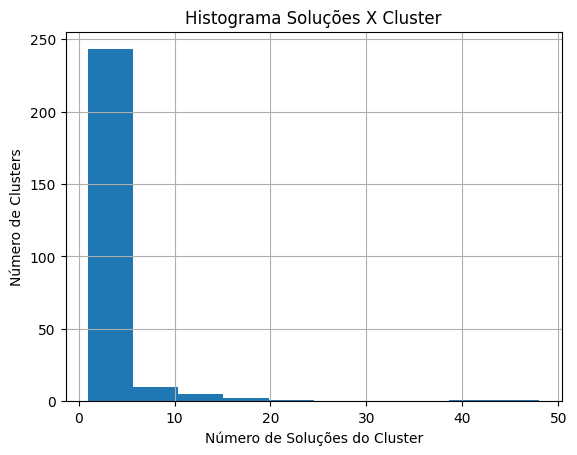

In [205]:
df_test['count'].hist()
# Add labels and a title
plt.xlabel('Número de Soluções do Cluster')
plt.ylabel('Número de Clusters')
plt.title('Histograma Soluções X Cluster')

#### Verificação da Regra de Pareto

Ordenar os clusters do maior para o menor

In [206]:
sorted_df = df_test['count'].sort_values(ascending=False)
sorted_df.head()

14    48
3     41
19    20
35    16
18    16
Name: count, dtype: int64

Calcular quanto é 20% do total de clusters e qual porcentagem de soluções atingimos com esses 20%

In [207]:
twenty_percent = round(total_clusters * 0.2)
print(f"With 20% ({twenty_percent}) of the {total_clusters} clusters,")

represented_solutions = sorted_df[:twenty_percent].sum()
percentage = round(represented_solutions/total_solutions * 100, 1)
print(f"we get {percentage}% ({represented_solutions}) of the {total_solutions} solutions")

With 20% (53) of the 263 clusters,
we get 62.9% (388) of the 617 solutions


O Inverso: Calcular quanto é 80% do total de soluções e quantos clusters precisamos para atingir esses 80%

In [208]:
eighty_percent = round(total_solutions * 0.8)

for i in range(1, len(sorted_df)):
    if sorted_df[:i].sum() >= eighty_percent:
        break

inverse_percentage = round(i/total_clusters * 100, 1)
print(f"We need {inverse_percentage}% ({i}) clusters to represent 80% ({eighty_percent}) of the solutions.")

We need 53.2% (140) clusters to represent 80% (494) of the solutions.
